In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data understanding

In [2]:
np.random.seed(1987)
N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()
train = pd.read_csv('../input/nyc-taxi-trip/train.csv')
test = pd.read_csv('../input/nyc-taxi-trip/test.csv')
sample_submission = pd.read_csv('../input/nyc-taxi-trip/sample_submission.csv')

Let's check the data files! According the data description we should find the following columns:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - duration of the trip in seconds

Obviously dropoff_datetime and trip_duration are only available for the train set.

## Number of data


In [3]:
print('We have {} training rows and {} test rows.'.format(train.shape[0], test.shape[0]))
print('We have {} training columns and {} test columns.'.format(train.shape[1], test.shape[1]))
train.head(2)


We have 1458644 training rows and 625134 test rows.
We have 11 training columns and 9 test columns.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


## Check duplicate and Nan


**Comment:** data seems to be cleaned quite thoroughly

In [4]:

print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops')
print('Train and test sets are distinct.') if len(np.intersect1d(train.id.values, test.id.values))== 0 else print('oops')
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] else print('oops')
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))
print("NaN Values in the DataFrame: ", train.isnull().sum())


Id is unique.
Train and test sets are distinct.
We do not need to worry about missing values.
The store_and_fwd_flag has only two values {'N', 'Y'}.
NaN Values in the DataFrame:  id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [5]:
# to data - time dtype
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


# Exploratory Data Analysis

## Target

In [6]:
train['trip_duration'].max() // 3600

979

We can see that the max trip_duration is ~ 1000 hours. Fortunately the evaluation metric is RMSLE and not RMSE . Outliers will cause less trouble. We could logtransform our target label and use RMSE during training.

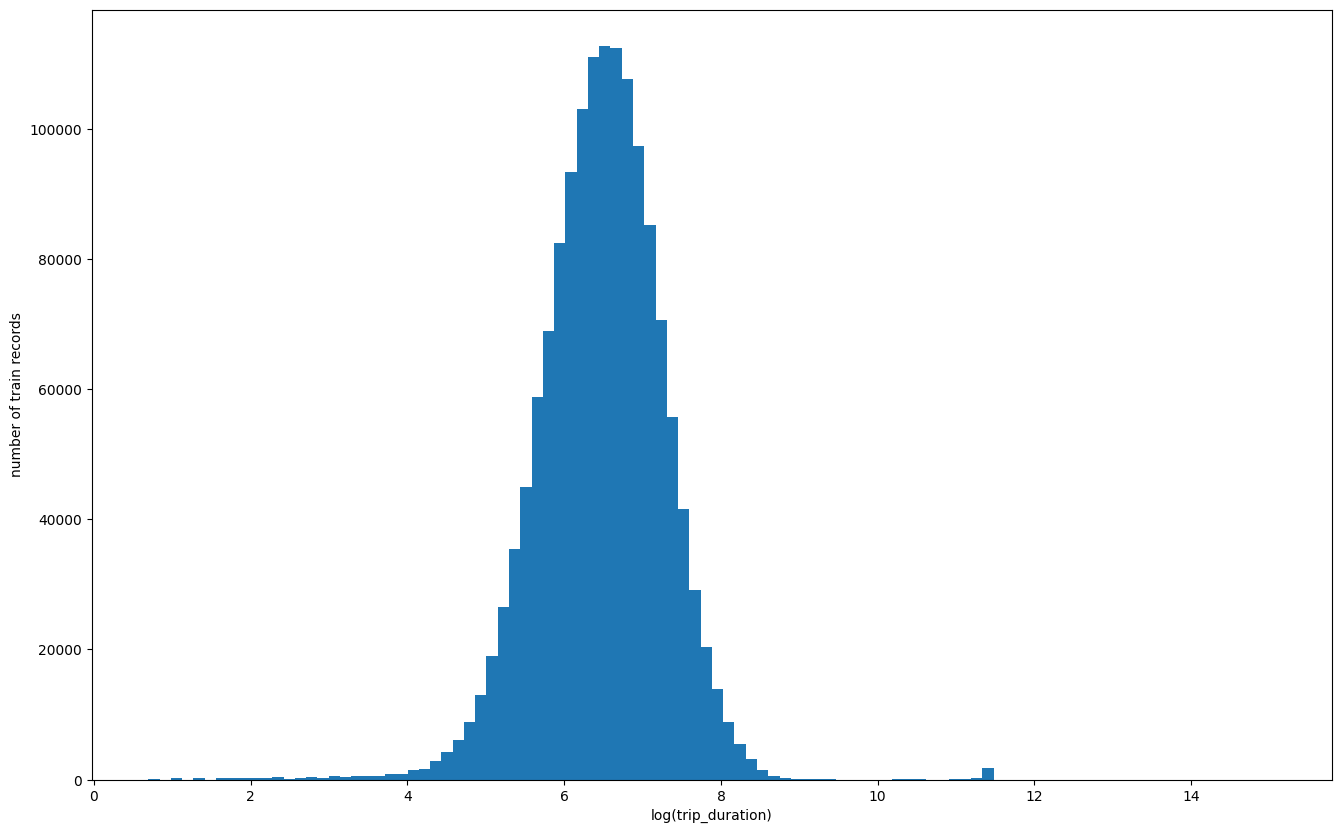

In [7]:
def plot_target(train):
    plt.hist(train['log_trip_duration'].values, bins=100)
    plt.xlabel('log(trip_duration)')
    plt.ylabel('number of train records')
    plt.show()
    
plot_target(train)

<Axes: >

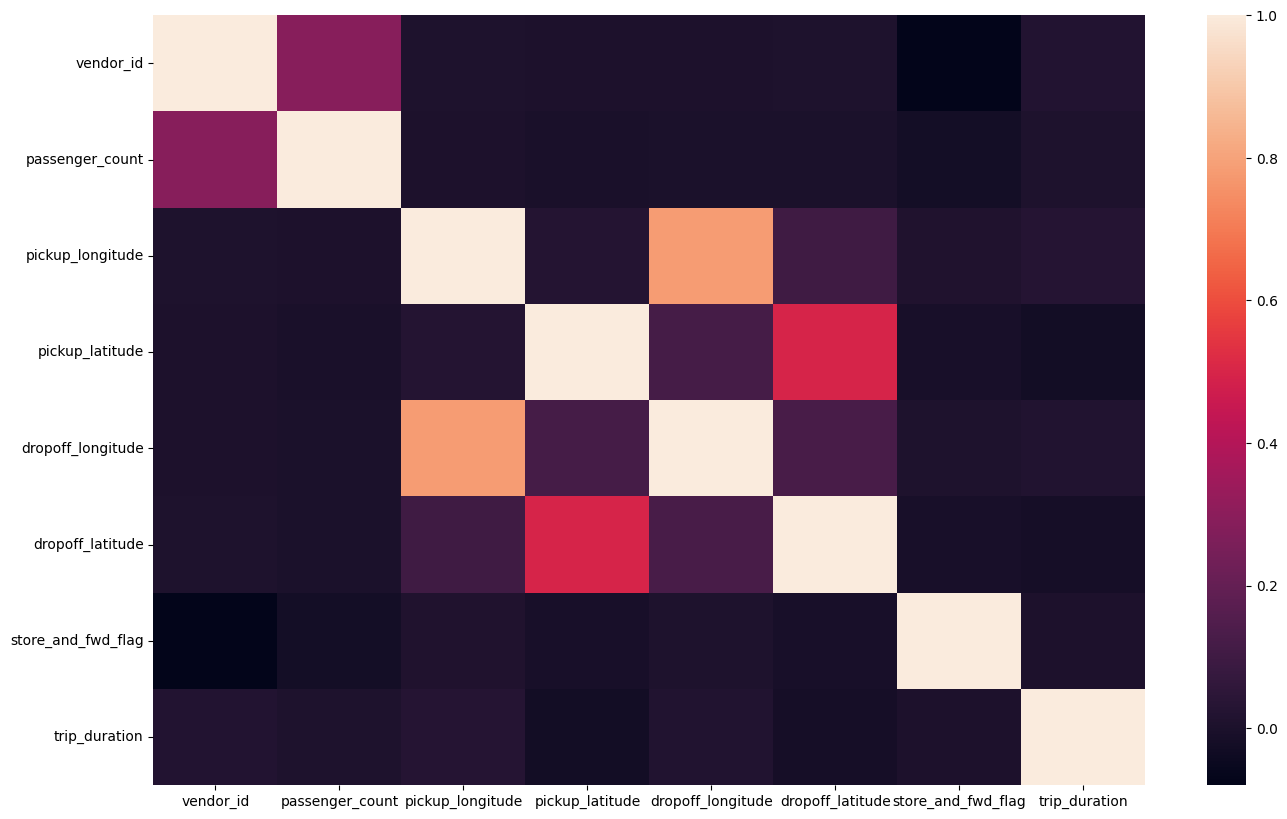

In [8]:
sns.heatmap(train.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime', 'log_trip_duration', 'pickup_date', 'check_trip_duration']).corr())

**Comment:** Here we see that:
* There is no significant correlation between target and each feature in the table, especially with "store_and_fwd_flag" and "latitude" infor.
* Vendor_id and passenger_count have a high correlation. Meaning that, 2 vendor have different target about the number of passengers in their trip.

## vendor_id and passenger_count

In [9]:
import time
s= time.time()
train['passenger_count'].value_counts().sort_index()
time.time() - s

0.013994932174682617

In [10]:
import matplotlib.pyplot as plt
def plot_distribution(train, test, column_name):
    train_vendor_counts = train[column_name].value_counts().sort_index()
    test_vendor_counts = test[column_name].value_counts().sort_index()

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    train_vendor_counts.plot(kind='bar', color='green', label='Train')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    test_vendor_counts.plot(kind='bar', color='orange', label='test')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')

    plt.legend()
    plt.tight_layout()
    plt.show()
    
def scatter_plot_two_feature(train, test, col1, col2):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(train[col1], train[col2], color='green', label='Train')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend()
    
    plt.subplot(1, 2, 1)
    plt.scatter(test[col1], test[col2], color='orange', label='Test')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    

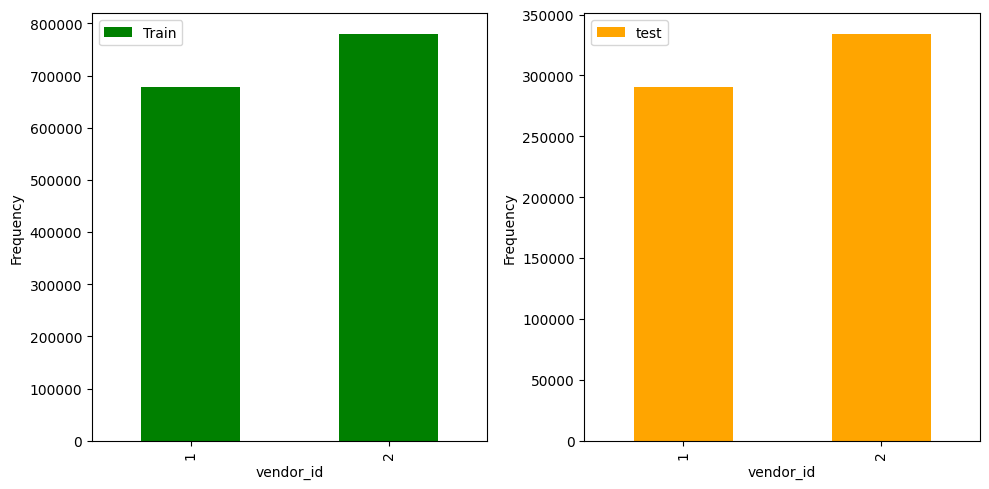

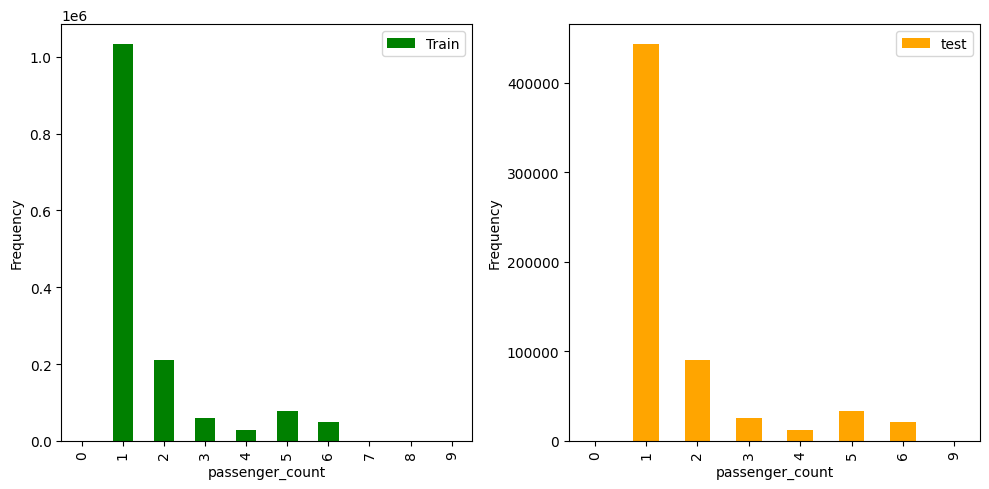

In [11]:
plot_distribution(train, test, 'vendor_id')
plot_distribution(train, test, 'passenger_count')

## Correlation between two feature

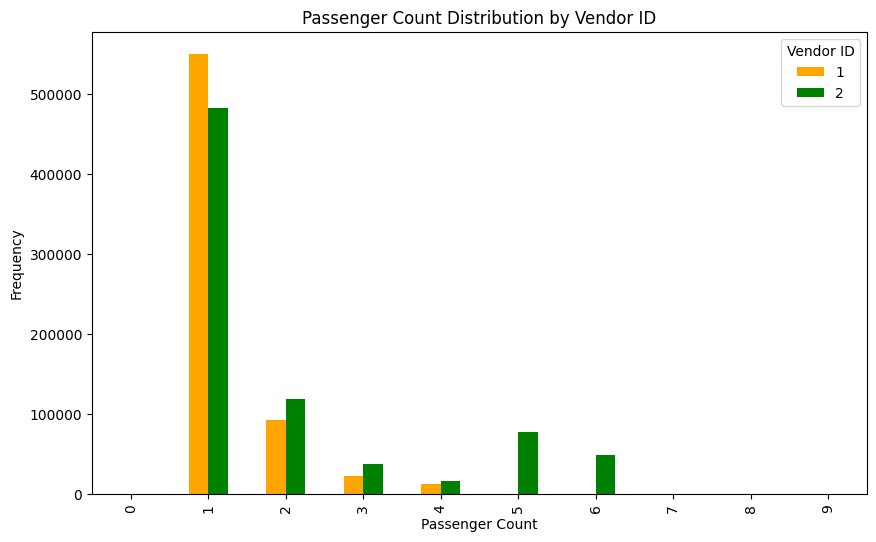

In [12]:
import matplotlib.pyplot as plt

grouped_data = train.groupby(['passenger_count', 'vendor_id']).size().unstack()

grouped_data.plot(kind='bar', stacked=False, figsize=(10, 6), color=['orange', 'green'])
plt.title('Passenger Count Distribution by Vendor ID')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.legend(title='Vendor ID', loc='upper right')
plt.show()

**Comment:** We can see that, vendor_id 2 is more frequency with trip with large passengers.


## Correlation with target

0.14042162895202637


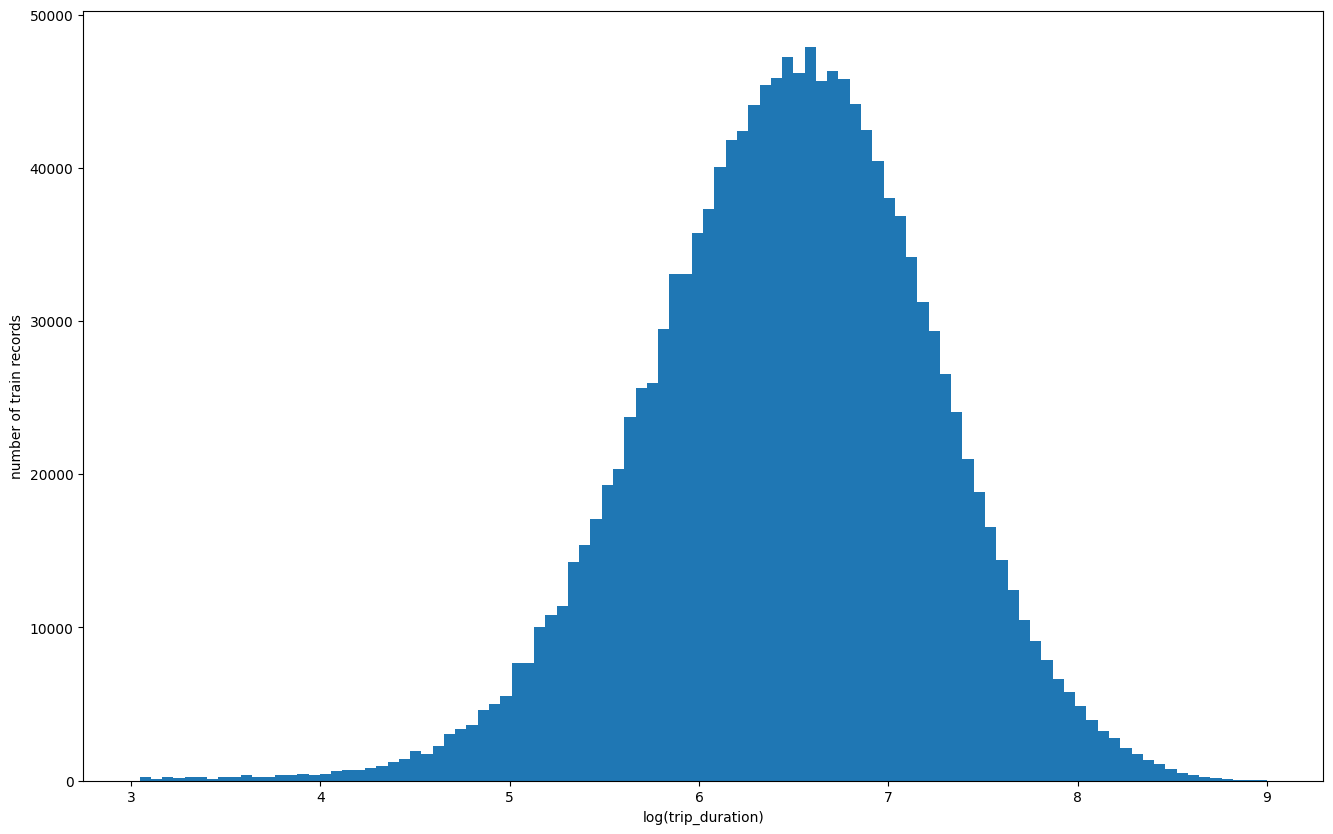

In [13]:
s = time.time()
filtered_df = train[(train['log_trip_duration']>3) & (train['log_trip_duration']<9)]
print(time.time() - s)
plot_target(filtered_df)

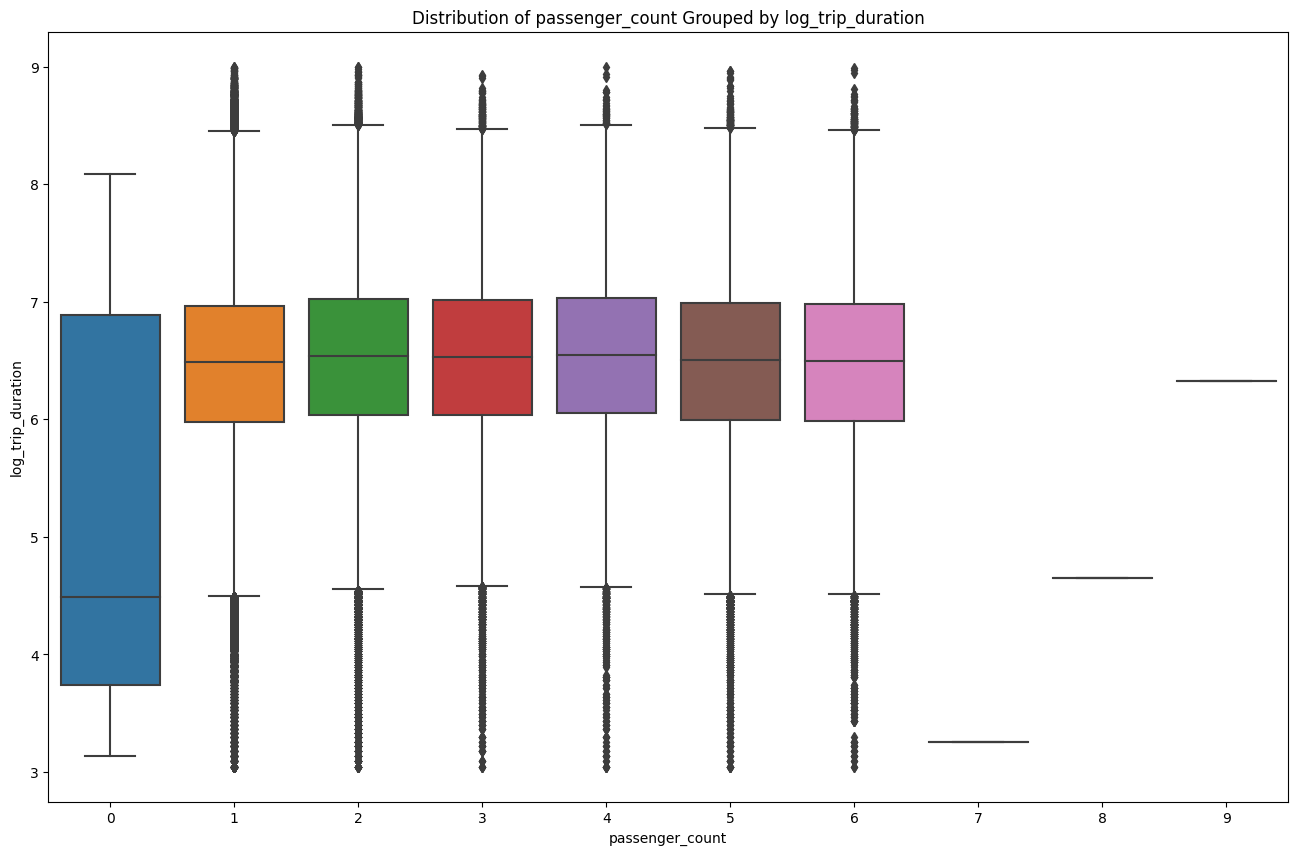

In [14]:
def box_plot(df, c1, c2):
    sns.boxplot(x=c1, y=c2, data=df)
    plt.xlabel(c1)
    plt.ylabel(c2)
    plt.title(f'Distribution of {c1} Grouped by {c2}')
    plt.show()
box_plot(filtered_df, 'passenger_count', 'log_trip_duration')

In [15]:
s = time.time()
filtered_df.groupby('passenger_count').size()
print(time.time() - s)

0.022039413452148438


In [16]:
s = time.time()
train['passenger_count']
print(time.time() - s)

9.894371032714844e-05


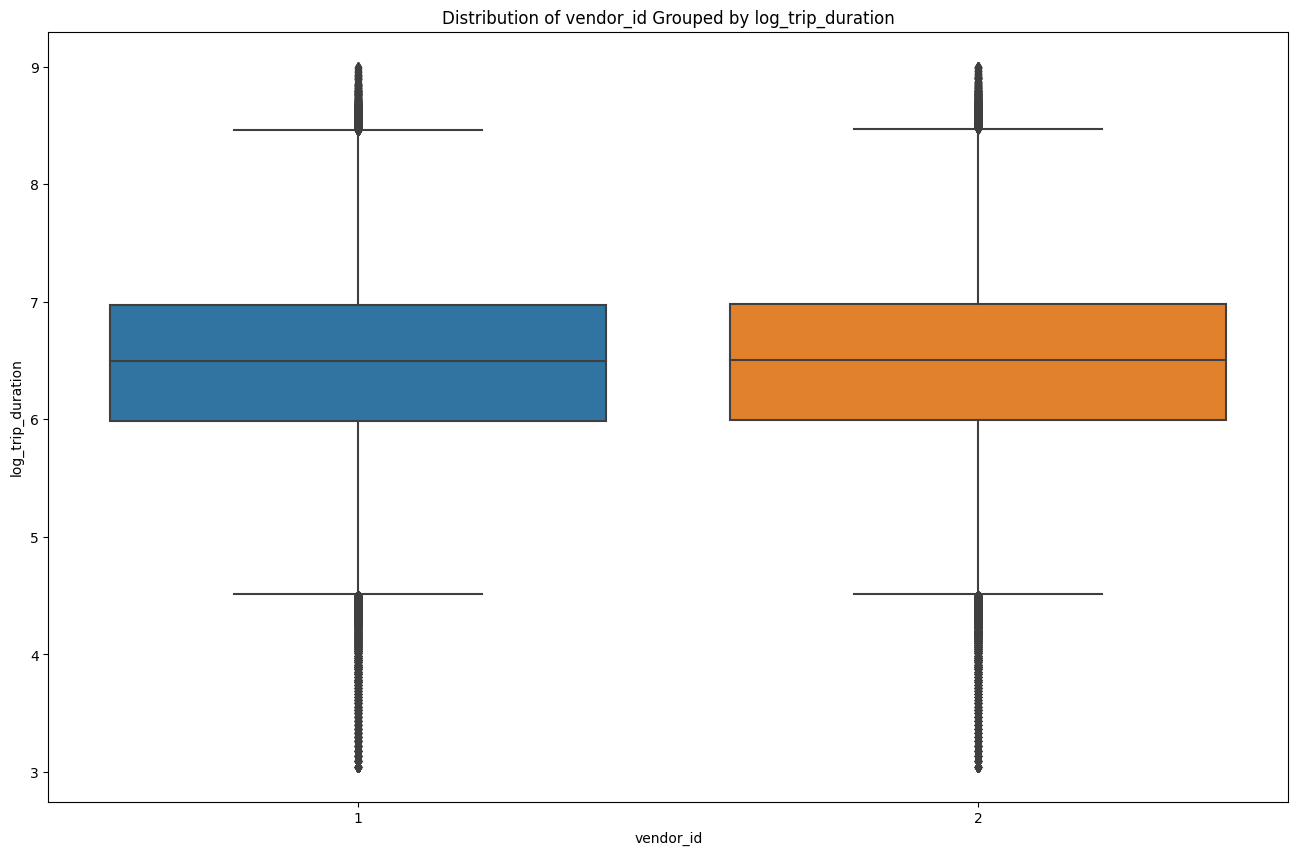

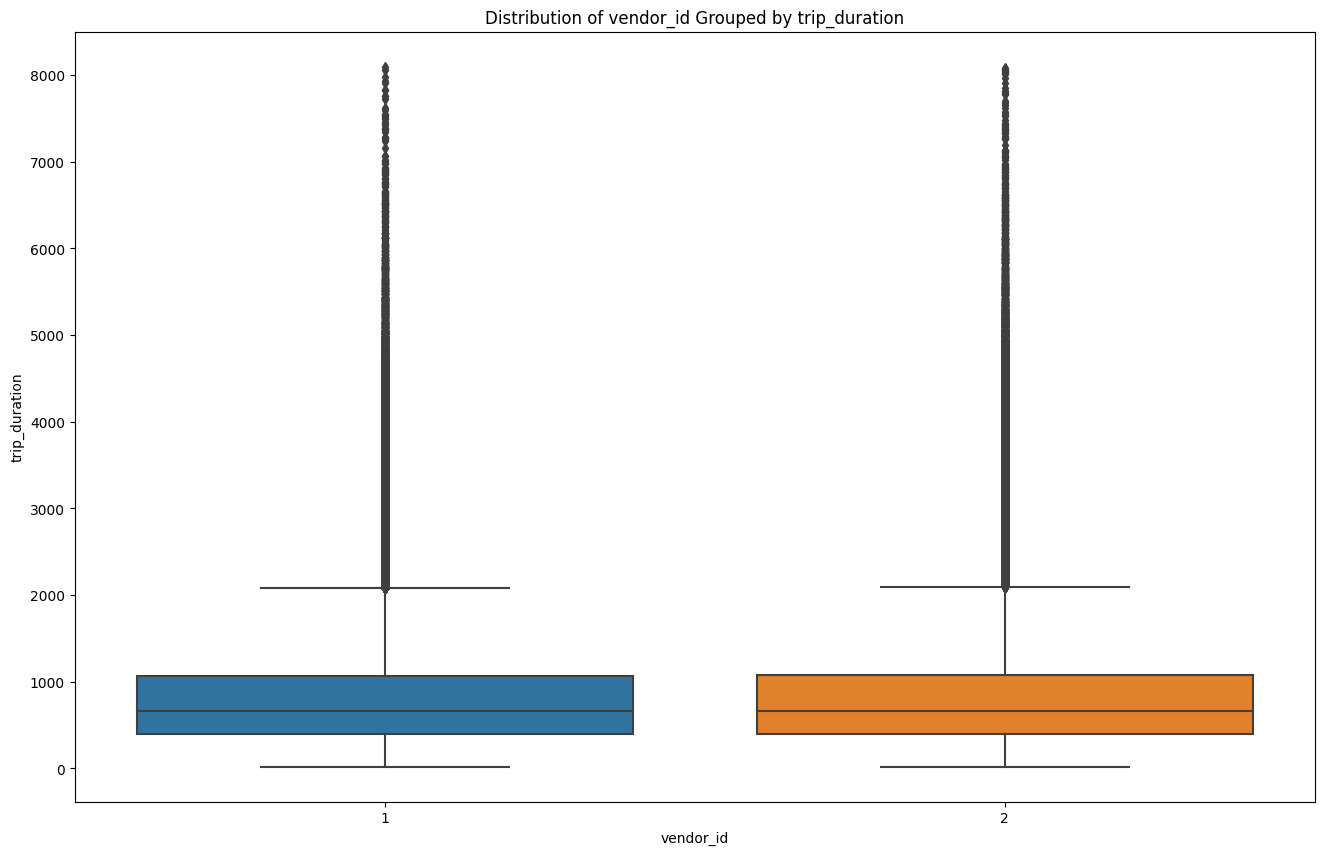

In [17]:
box_plot(filtered_df, 'vendor_id', 'log_trip_duration')
box_plot(filtered_df, 'vendor_id', 'trip_duration')

**Comments:** 
* Unless passenger_count = 7,8,9 have only one sample, so we dont consider that case.
* passenger_count = 0, meaning that, there is no passenger in the trip?? So the driver just drive alone in this trip, and it has a significant short trip duration.
* when 1 <= passenger_count <= 6, there no significant different between the trip duration among of the passenger_count.
* there no significant different between the trip duration among of the vendor_id.

## Coordinates

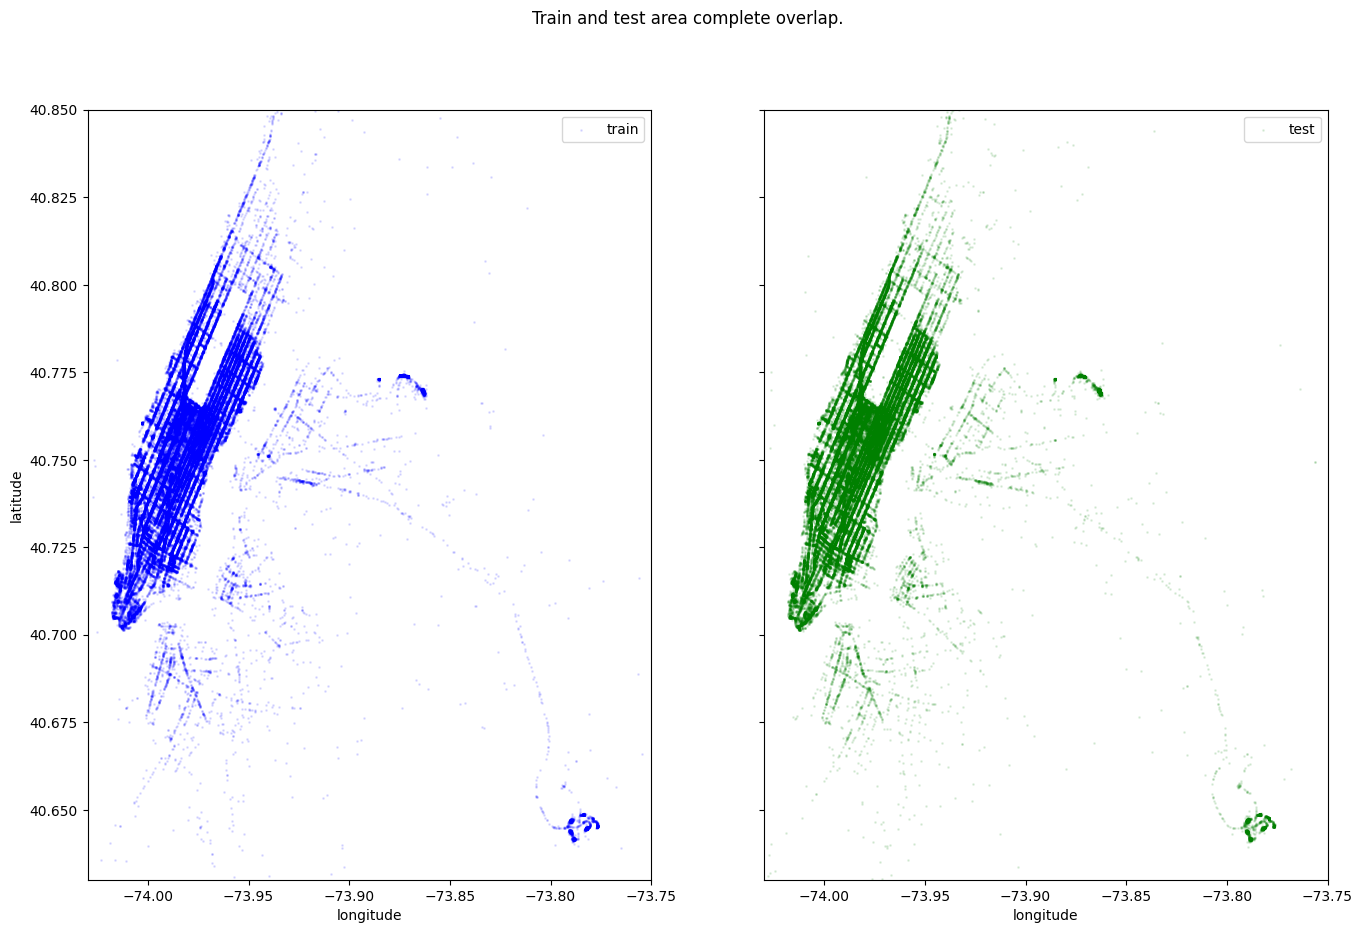

In [18]:
def plot_coordinates(train, test):    
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
    ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
                  color='blue', s=1, label='train', alpha=0.1)
    ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N],
                  color='green', s=1, label='test', alpha=0.1)
    fig.suptitle('Train and test area complete overlap.')
    ax[0].legend(loc=0)
    ax[0].set_ylabel('latitude')
    ax[0].set_xlabel('longitude')
    ax[1].set_xlabel('longitude')
    ax[1].legend(loc=0)
    plt.ylim(city_lat_border)
    plt.xlim(city_long_border)
    plt.show()
plot_coordinates(train, test)

Now, look at the heatmap of correlation matrix in the previous section, we see that, the correlation between target and longtitude is higher than latitude. Maybe the reason is because the city's terrain will vary more along the longitude.

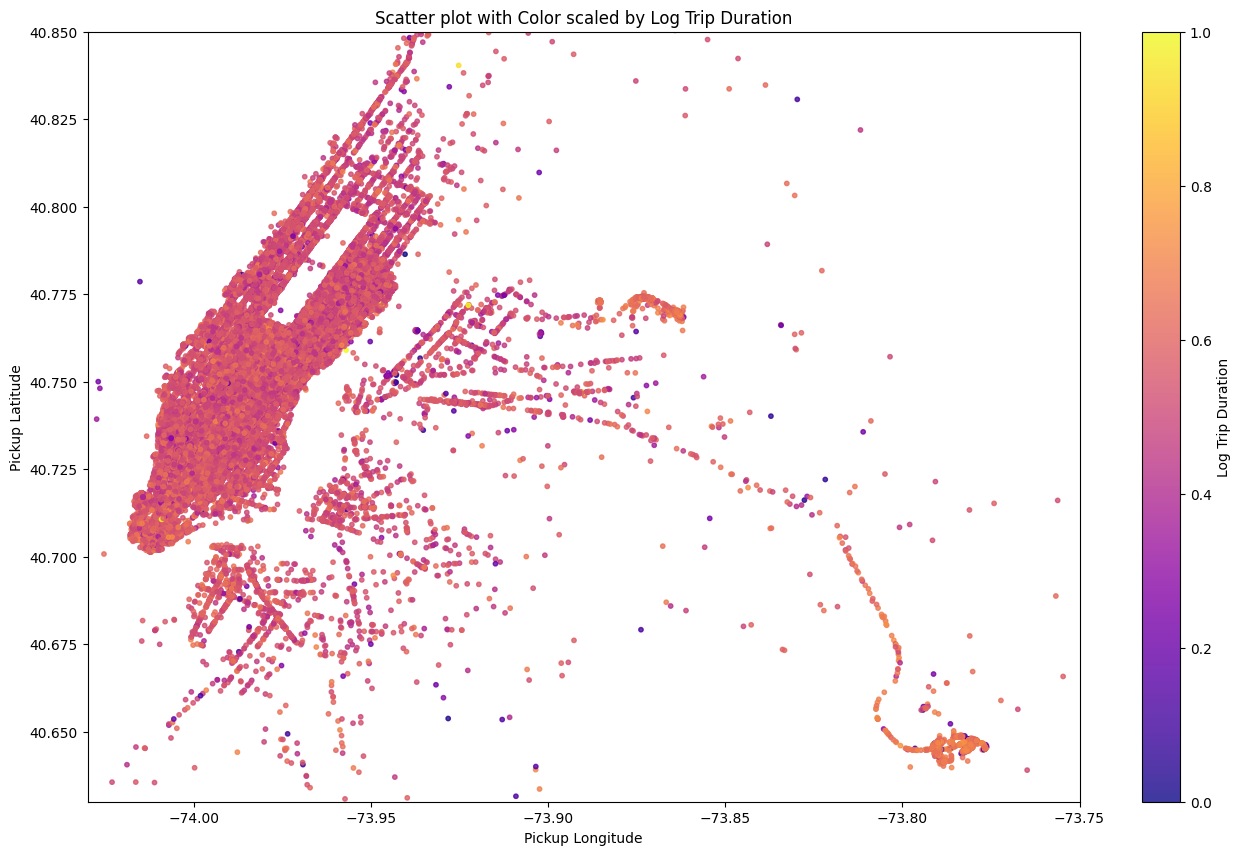

In [19]:
import matplotlib.colors as mcolors
def plot_coordinates_with_target(train, scale_column):    
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    
    min_log_trip_duration = train[scale_column][:N].min()
    max_log_trip_duration = train[scale_column][:N].max()
    normalized_duration = (train[scale_column][:N] - min_log_trip_duration) / (max_log_trip_duration - min_log_trip_duration)
    
    norm = mcolors.Normalize(vmin=train[scale_column][:N].min(), vmax=train[scale_column][:N].max())
    plt.scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
            c=normalized_duration, cmap='plasma', s=10, label='train', alpha=0.8)
    
    plt.colorbar(label='Log Trip Duration')
    plt.xlabel('Pickup Longitude')
    plt.ylabel('Pickup Latitude')
    plt.title('Scatter plot with Color scaled by Log Trip Duration')
    plt.ylim(city_lat_border)
    plt.xlim(city_long_border)
    plt.show()
plot_coordinates_with_target(train, 'log_trip_duration')

**Assumtion about terrain:** We can see that the coordinates of pick-up points often accurately describe the city's terrain. For example, the curve on the left side of the image looks like an avenue or highway connecting the city center to another location. And of course, trips on the highway will often take longer than trips in the city.

## store_and_fwd_flag

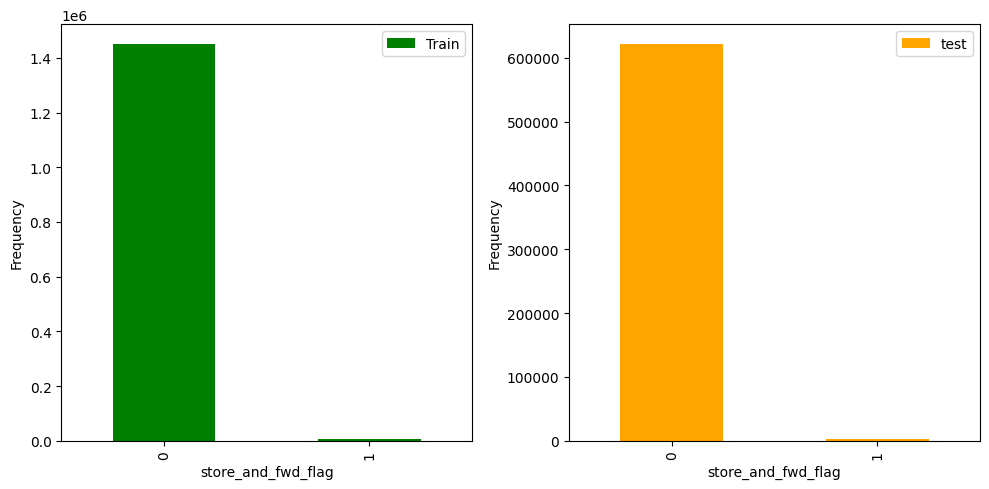

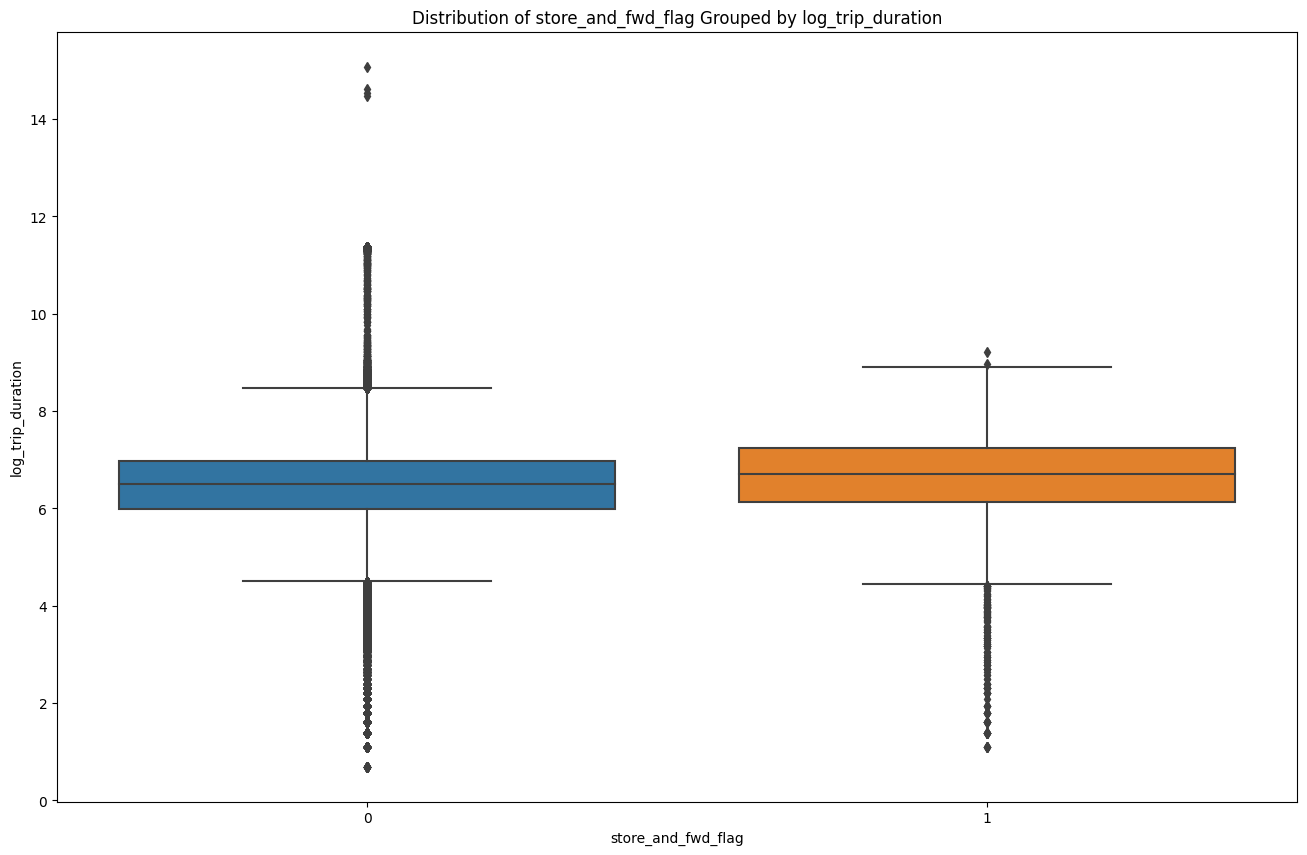

store_and_fwd_flag
0    1450599
1       8045
dtype: int64

In [20]:
plot_distribution(train, test, 'store_and_fwd_flag')
box_plot(train, 'store_and_fwd_flag', 'log_trip_duration')
train.groupby('store_and_fwd_flag').size()

**Comments**
* We see that, there is only 8045 sample that store data in the taxi after foward. And the trip_duration of such samples is quite higher.

**Data about time we need to break down before analysis**

-------------------------------------------------------------------------------------------------------------------------------------------------------

# Feature Extraction

## PCA
We use PCA to transform longitude and latitude coordinates. In this case it is not about dimension reduction since we transform 2D-> 2D. The rotation could help for decision tree splits.

In [21]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

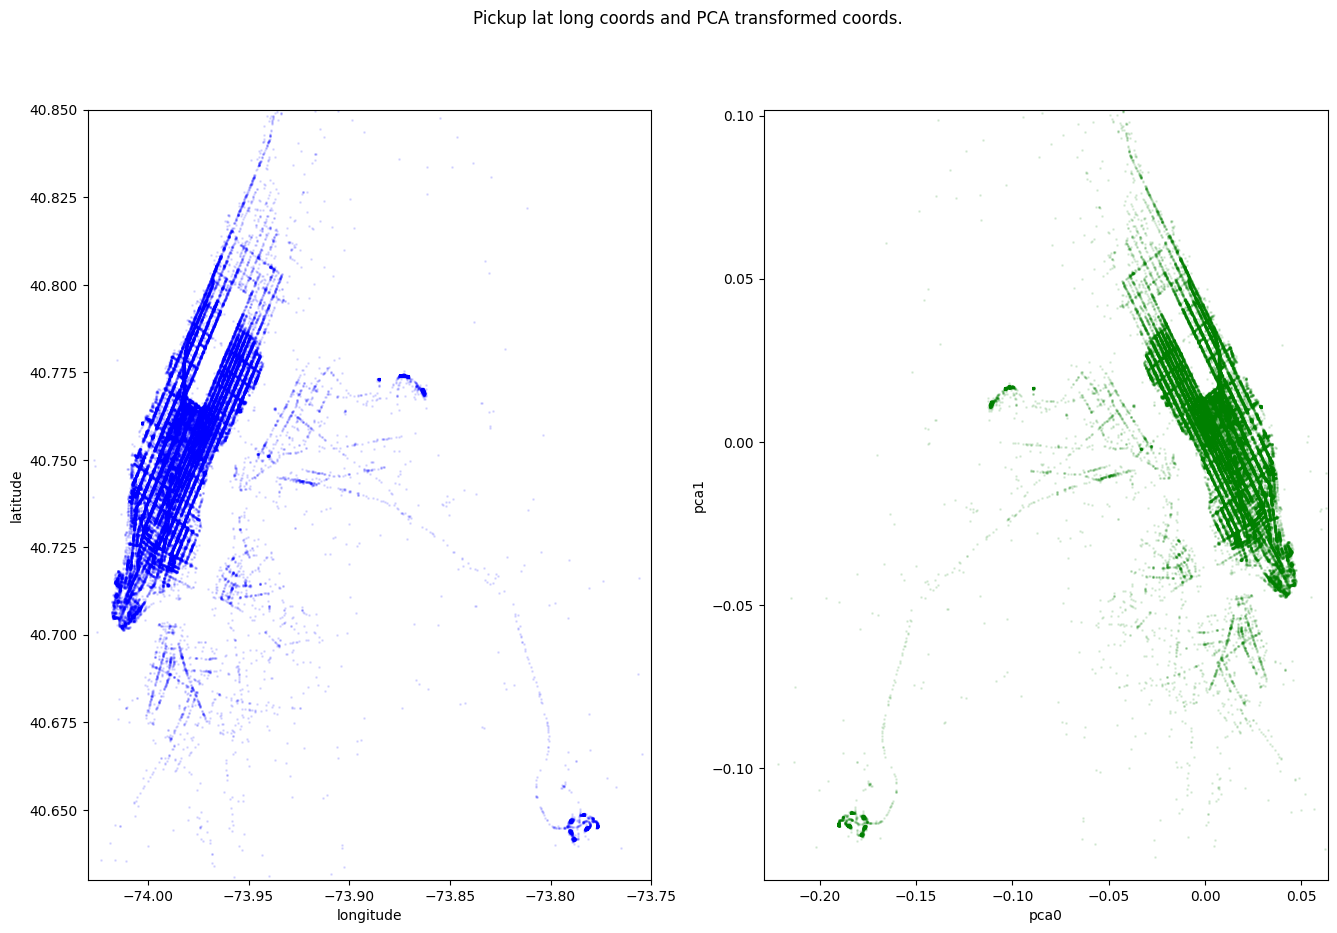

In [22]:
fig, ax = plt.subplots(ncols=2)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

## Distance
Let's calculate the distance (km) between pickup and dropoff points. Currently Haversine is used, geopy has another heuristics (vincenty() or great_circle()) if you prefer.
The cabs are not flying and we are in New York so we could check the Manhattan (L1) distance too :) 

pd.DataFrame.apply() would be too slow so the haversine function is rewritten to handle arrays.
We extraxt the middle of the path as a feature as well.

In [23]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

Now let's check **Assumtion about terrain** we talk before

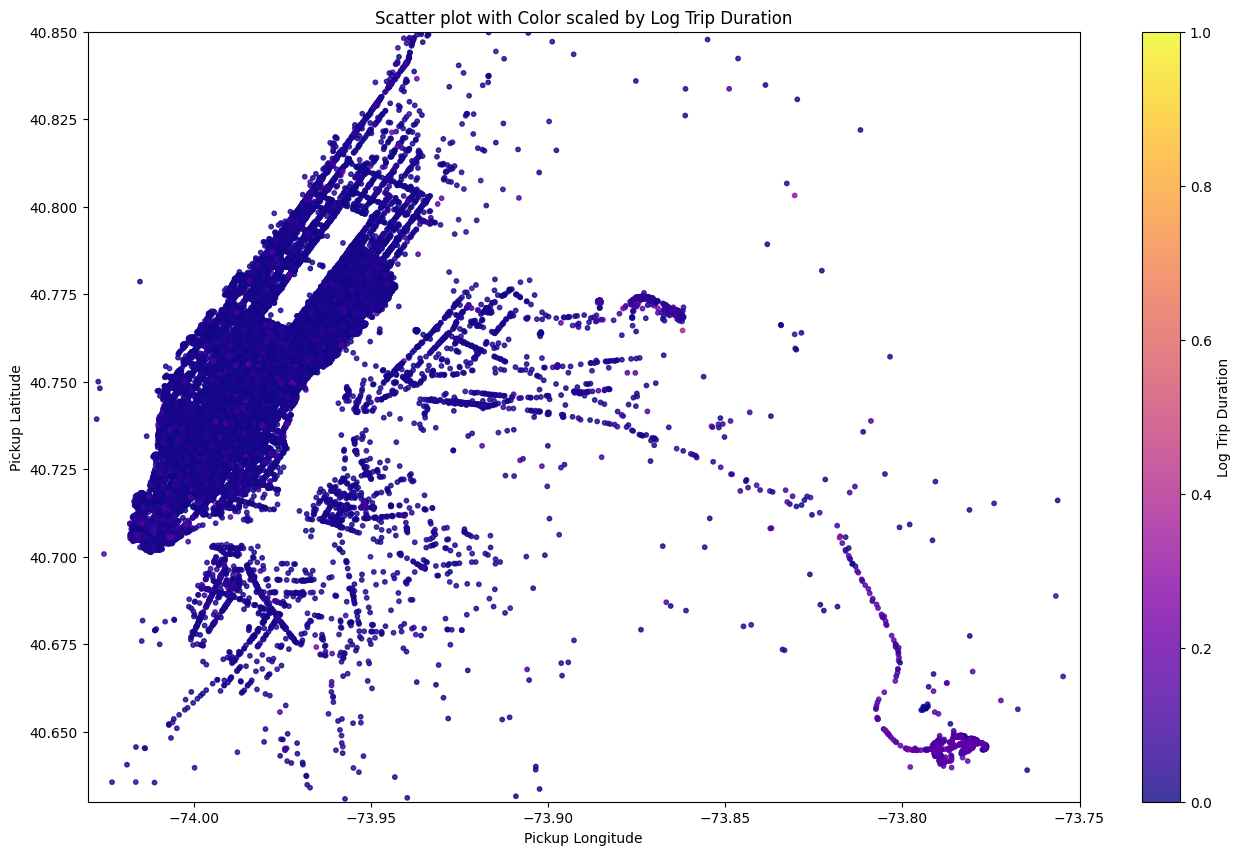

In [24]:
plot_coordinates_with_target(train, 'distance_dummy_manhattan')

(0.0, 12.0)

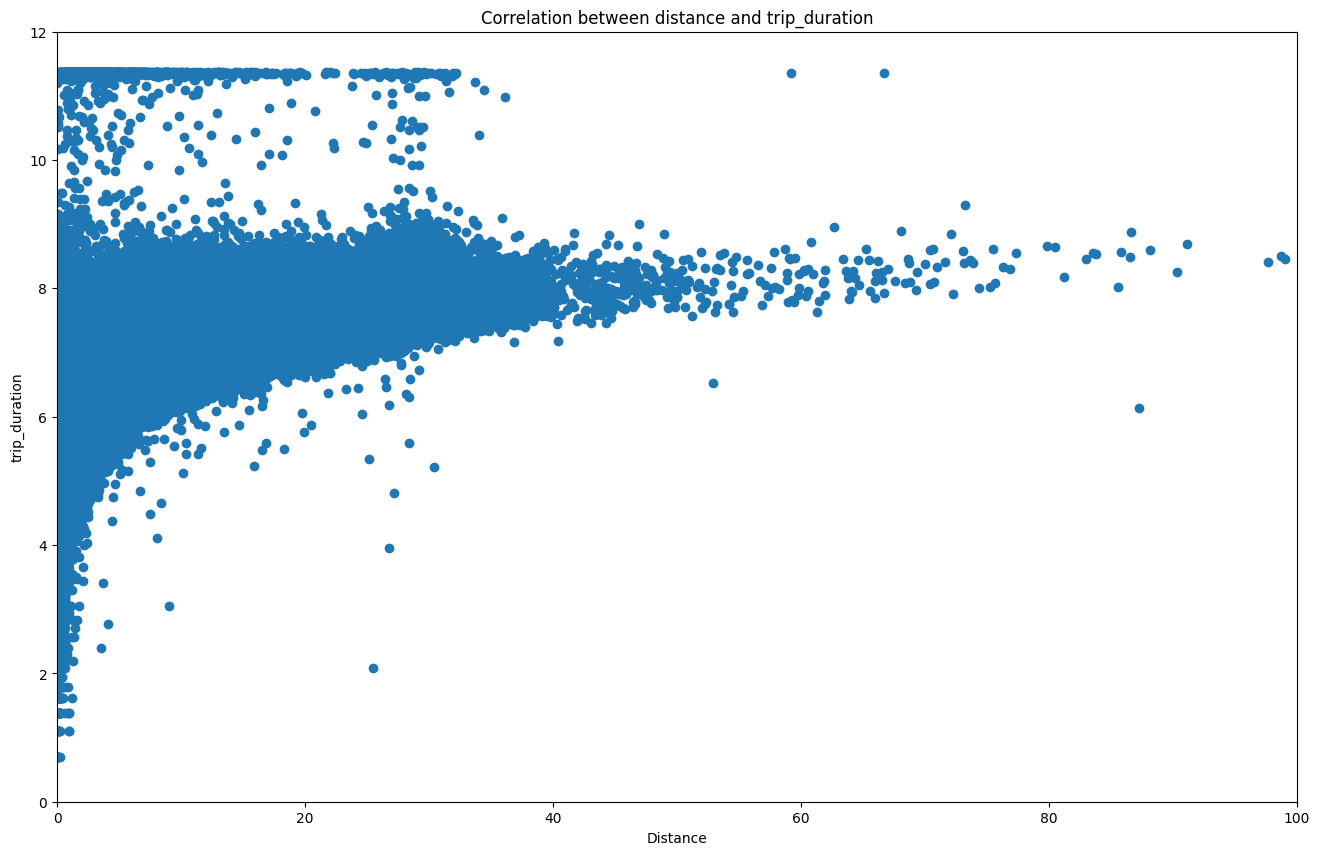

In [25]:
plt.scatter(train['distance_dummy_manhattan'], train['log_trip_duration'])
plt.title("Correlation between distance and trip_duration")
plt.xlabel("Distance")
plt.ylabel("trip_duration")
plt.xlim(0, 100)
plt.ylim(0, 12)

We see that, the trip with long distence often take mote time. But, the trip with small distence sometimes it longer than we think. **Let's analyze that case** 

## Datetime features

In [26]:
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
# test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

In [27]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

## Clustering

In [28]:
sample_ind = np.random.permutation(len(coords))[:500000]
start = time.time()
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])
print(time.time() - start)

1.8229436874389648


In [29]:
t1 = dt.datetime.now()
print('Time till clustering: %i seconds' % (t1 - t0).seconds)

Time till clustering: 52 seconds


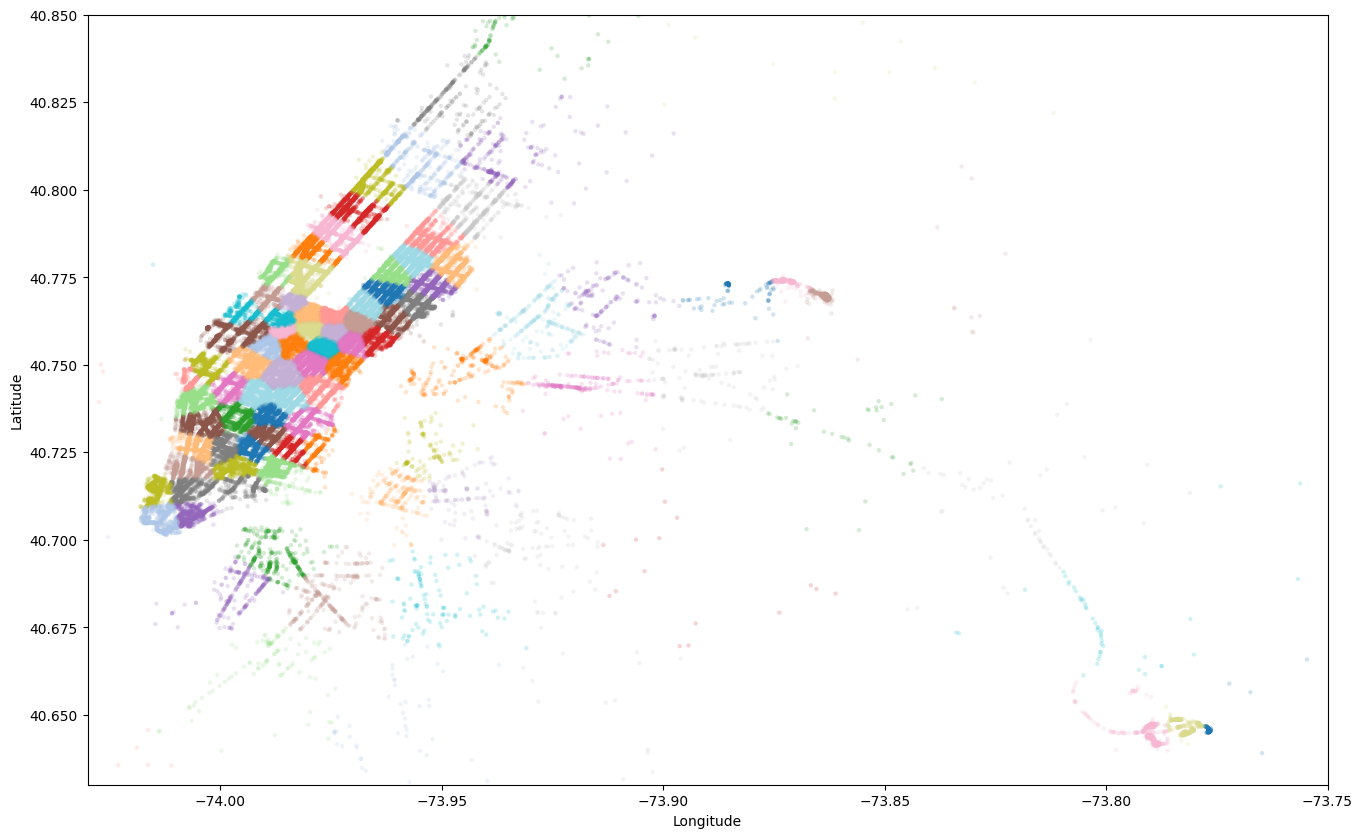

In [30]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

## Feature check before modeling
It might save you some headache to check your train and test feature distributions before modeling. Usually in kaggle competitions train and test sets are iid. If there is huge differenc between train and test set than probably you have a bug in your feature extraction pipeline.

In [31]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime',
                           'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m',
                           'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin',
                           'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()
y = np.log(train['trip_duration'].values + 1)

t1 = dt.datetime.now()
print('Feature extraction time: %i seconds' % (t1 - t0).seconds)

['check_trip_duration' 'dropoff_datetime' 'log_trip_duration'
 'trip_duration']
We have 24 features.
Feature extraction time: 53 seconds


In [32]:
feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

,feature,train_test_mean_diff
1,passenger_count,0.002057
12,distance_dummy_manhattan,0.002201
20,pickup_dt,0.002648
7,pickup_pca0,0.002774
10,dropoff_pca1,0.002833


In [33]:
feature_stats = feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature', 'train_nan', 'test_nan', 'train_test_nan_diff']].tail()

,feature,train_nan,test_nan,train_test_nan_diff
6,store_and_fwd_flag,0.0,0.0,0.0
5,dropoff_latitude,0.0,0.0,0.0
16,center_longitude,0.0,0.0,0.0
7,pickup_pca0,0.0,0.0,0.0
10,dropoff_pca1,0.0,0.0,0.0


In [34]:
feature_names

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'pickup_pca0',
 'pickup_pca1',
 'dropoff_pca0',
 'dropoff_pca1',
 'distance_haversine',
 'distance_dummy_manhattan',
 'direction',
 'pca_manhattan',
 'center_latitude',
 'center_longitude',
 'pickup_weekday',
 'pickup_hour',
 'pickup_minute',
 'pickup_dt',
 'pickup_week_hour',
 'pickup_cluster',
 'dropoff_cluster']

Even the top mean difference is less than 1% of the standard deviation. We have a few missing values but the missing rates are the same. Fortunately xgboost can handle missing values.

# Modeling

In [35]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names], y, test_size=0.2, random_state=1987)
Xtr

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_pca0,pickup_pca1,dropoff_pca0,...,pca_manhattan,center_latitude,center_longitude,pickup_weekday,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,pickup_cluster,dropoff_cluster
723034,1,4,-73.968277,40.770920,-73.951118,40.793507,0,-0.006338,0.019218,-0.024791,...,0.039995,40.782213,-73.959698,5,13,54,5579642.0,133,98,37
514508,1,1,-73.971939,40.760151,-73.988632,40.737087,0,-0.002050,0.008682,0.015967,...,0.040062,40.748619,-73.980286,1,10,57,13690641.0,34,47,0
779835,1,1,-73.974998,40.753635,-73.975456,40.765354,0,0.001386,0.002357,0.001156,...,0.011956,40.759495,-73.975227,2,15,43,4117388.0,63,92,36
319158,1,4,-73.945351,40.779438,-73.954491,40.781052,0,-0.029724,0.026376,-0.020695,...,0.011177,40.780245,-73.949921,6,19,5,6289489.0,163,18,99
672992,1,1,-73.994064,40.740303,-73.992020,40.749260,0,0.021201,-0.009834,0.018634,...,0.011388,40.744781,-73.993042,0,21,19,6988726.0,21,97,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276038,1,4,-73.987228,40.759624,-73.986679,40.747765,0,0.013244,0.009053,0.013391,...,0.012019,40.753695,-73.986954,5,18,35,13458929.0,138,65,49
1257438,1,1,-73.971764,40.781925,-73.959259,40.775097,0,-0.003503,0.030408,-0.015585,...,0.019633,40.778511,-73.965511,5,7,4,8579038.0,127,68,29
29418,2,3,-73.988342,40.764172,-73.939751,40.806961,0,0.014089,0.013658,-0.036929,...,0.090883,40.785566,-73.964046,0,21,27,1546029.0,21,91,44
1284003,1,1,-73.982025,40.783302,-73.968575,40.791439,0,0.006661,0.032385,-0.007244,...,0.021239,40.787371,-73.975300,0,7,32,8148745.0,7,10,34


## Metric

In [36]:
def evaluate_metric(y, y_pred):
    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(y - y_pred))
    
    # Mean Squared Error (MSE)
    mse = np.mean((y - y_pred) ** 2)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((y - y_pred) ** 2))
    
    # Root Mean Squared Log Error (RMSLE)
    rmsle = np.sqrt(np.mean((np.log(y_pred + 1) - np.log(y + 1))**2))
    
    # R-squared 
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y))**2)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(2 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred))) * 100
    
    # Symmetric Mean Absolute Percentage Error (SMAPE)
    smape = np.mean(2 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred)))*100
    
    # Mean Directional Accuracy (MDA)
    mda = np.mean(np.sign(y[2:] - y[1:-1]) == np.sign(y_pred[2:] - y[1:-1]))
    
    # Median Absolute Error (MedAE)
    medAE = np.median(np.abs(y - y_pred))
    
    # Explained Variance Score (EVS)
    evs = 1 - np.var(y - y_pred) / np.var(y)
    
    metrics_df = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'RMSE', 'RMSLE', 'R2', 'MAPE', 'SMAPE', 'MDA', 'MedAE', 'EVS'],
        'Value': [mae, mse, rmse, rmsle, r2, mape, smape, mda, medAE, evs]
    })

    return metrics_df

In [37]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

## GPU check an CUML

In [ ]:
!nvidia-smi

In [ ]:
!pip install cuml

In [ ]:
import cuml
cuml.__version__

In [ ]:
import cudf
cudf.__version__

## Modeling

### Sklearn version

In [ ]:
import numpy as np
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import time

eval_df = pd.DataFrame()

classifiers = [
#     linear_model.LinearRegression(),
#     linear_model.Lasso(),
#     linear_model.Ridge(),
#     linear_model.ElasticNet(),
# #     RandomForestRegressor(max_depth=10, n_estimators=10),
# #     AdaBoostRegressor(n_estimators =10),
# #     GradientBoostingRegressor(max_depth=10, n_estimators =10),
    GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
    ]

for item in classifiers:
    start_time = time.time()
    print(item)
    clf = item
    clf.fit(Xtr, ytr)
    yv_pred = clf.predict(Xv)
    end_time = time.time()
    print(evaluate_metric(yv, yv_pred))
    print("Evaluate time: ", end_time-start_time)
    

In [ ]:
start_time = time.time()

clf = GradientBoostingRegressor(
    n_estimators=1000,  # Set a large number of estimators for early stopping
    max_depth=5,
    learning_rate=0.1,
    validation_fraction=0.1,
    n_iter_no_change=50,
    tol=0.01
)

clf.fit(Xtr, ytr)

execution_time = time.time() - start_time
print("Training time:", execution_time)



In [ ]:
start_time = time.time()
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 100, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)
execution_time = time.time() - start_time
print(execution_time)

In [ ]:
yv_pred = model.predict(dvalid)
evaluate_metrix(yv, yv_pred)

In [ ]:
print('Modeling RMSLE %.5f' % model.best_score)
t1 = dt.datetime.now()
print('Training time: %i seconds' % (t1 - t0).seconds)

In [ ]:
ytest = model.predict(dtest)
ytest

### Cuml version

In [ ]:
break

In [ ]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names], y, test_size=0.2, random_state=1987)

In [ ]:
#CuML metric
from cuml.metrics.regression import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def cuml_evaluate_metric(y, y_pred):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, y_pred).get().round(6)
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y, y_pred, squared=True).get().round(6)
    
    # Root Mean Squared Error (RMSE)
    rmse = mean_squared_error(y, y_pred, squared=False).get().round(6)
    
    # Root Mean Squared Log Error (RMSLE)
    rmsle = mean_squared_log_error(y, y_pred).get().round(6)
    
    # R-squared 
    r2 = r2_score(y, y_pred)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(2 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred))) * 100
    
    # Symmetric Mean Absolute Percentage Error (SMAPE)
    smape = np.mean(2 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred)))*100
    
    # Mean Directional Accuracy (MDA)
    mda = np.mean(np.sign(y[2:] - y[1:-1]) == np.sign(y_pred[2:] - y[1:-1]))
    
    # Median Absolute Error (MedAE)
    medAE = np.median(np.abs(y - y_pred))
    
    # Explained Variance Score (EVS)
    evs = 1 - np.var(y - y_pred) / np.var(y)
    
#     print(mae)
#     print('Value', [mae, mse, rmse, rmsle, r2, mape, smape, mda, medAE, evs])
    
    metrics_df = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'RMSE', 'RMSLE', 'R2', 'MAPE', 'SMAPE', 'MDA', 'MedAE', 'EVS'],
        'Value': [mae, mse, rmse, rmsle, r2, mape, smape, mda, medAE, evs]
    })

    return metrics_df


In [ ]:
Xtr = cudf.DataFrame.from_pandas(Xtr)
Xv = cudf.DataFrame.from_pandas(Xv)

In [ ]:
import time

eval_df = pd.DataFrame()

classifiers = [
    cuml.LinearRegression(),
    cuml.Lasso(),
    cuml.Ridge(),
    cuml.ElasticNet(),
    cuml.ensemble.RandomForestRegressor(max_depth=10, n_estimators=10),
    ]

for item in classifiers:
    start_time = time.time()
    print(item)
    clf = item
    reg = clf.fit(Xtr, ytr)
    yv_pred = clf.predict(Xv)
    end_time = time.time()
    print(evaluate_metric(yv, yv_pred))
    print("Evaluate time: ", end_time-start_time)
    

In [ ]:
start_time = time.time()
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'tree_method': 'gpu_hist', 'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 100, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)
execution_time = time.time() - start_time
print(execution_time)

In [ ]:
columns = df.columns


In [ ]:
yv_pred = model.predict(dvalid)
evaluate_metric(yv, yv_pred)

## Benchmark cuML

In [ ]:
columns = ['Model', 'sklearn (CPU)', 'cuML (GPU)']
df_time = pd.DataFrame(columns=columns)
df_time.loc[len(df_time)] = ['LinearRegression', 2.40, 0.16]
df_time.loc[len(df_time)] = ['Lasso', 0.61, 0.16]
df_time.loc[len(df_time)] = ['Ridge', 0.41, 0.25]
df_time.loc[len(df_time)] = ['ElasticNet', 0.99, 0.19]
df_time.loc[len(df_time)] = ['RandomForestRegressor', 221.17, 1.04]
df_time.loc[len(df_time)] = ['XGBoost', 134.57, 3.86]
df_time

In [ ]:
    
X_axis = np.arange(len(df_time[4:])) 

plt.figure(figsize=(8,8))

plt.bar(X_axis - 0.2, df_time['sklearn (CPU)'][4:], 0.4, label = 'sklearn (CPU)') 
plt.bar(X_axis + 0.2, df_time['cuML (GPU)'][4:], 0.4, label = 'cuML (GPU)') 

plt.xticks(X_axis, df_time['Model'][4:]) 
plt.xlabel("Model", fontsize=18) 
plt.ylabel("Time (s)", fontsize=18) 
plt.title("Benchmark time linear model", fontsize=18) 
plt.legend() 
plt.show() 

## Some benchmark pandas, vaex, cudf, polars

In [ ]:
# Import
import numpy as np
import pandas as pd
# import cudf.pandas
import polars as pl
import vaex

import time

### task1: read data

In [ ]:
# Read data frame as pandas
s = time.time()
pd_train = pd.read_csv('../input/nyc-taxi-trip/train.csv')
pd_test = pd.read_csv('../input/nyc-taxi-trip/test.csv')
e = time.time() - s
read_data_time.append(e)
print(e)

In [ ]:
s = time.time()
pl_train = pl.read_csv('../input/nyc-taxi-trip/train.csv')
pl_test = pl.read_csv('../input/nyc-taxi-trip/test.csv')
e = time.time() - s
read_data_time.append(e)
print(e)

In [ ]:
s = time.time()
vaex_train = vaex.from_csv('../input/nyc-taxi-trip/train.csv')
vaex_test = vaex.from_csv('../input/nyc-taxi-trip/test.csv')
e = time.time() - s
read_data_time.append(e)
print(e)

In [ ]:
s = time.time()
cudf_train = cudf.read_csv('../input/nyc-taxi-trip/train.csv')
cudf_test = cudf.read_csv('../input/nyc-taxi-trip/test.csv')
e = time.time() - s
print(e)

In [ ]:
import cudf
cudf.__version__

In [ ]:
%load_ext cudf.pandas

### pandas

In [ ]:
# create random DataFrame with 10 million rows and 3 columns
pd_df = pd.DataFrame(np.random.rand(10000000, 2), columns=['a', 'b'])
pd_df['c'] = np.random.randint(0, 6, size=10_000_000)

%timeit pd_df['a'].mean() # Mean
%timeit pd_df['a'].std()  # std
%timeit pd_df[(pd_df['b'] > 0.3) & (pd_df['b'] < 0.7)] # Filter
%timeit pd_df.groupby('c').size() # Groupby
%timeit np.log(pd_df['c']+1) # Apply math function

# 37.6 ms ± 918 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 109 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 172 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 186 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 59.3 ms ± 751 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

time_pandas = [37.6, 109, 172, 186, 59.3]

### vaex

In [ ]:
import vaex
import numpy as np

# Create a Vaex DataFrame
vaex_df = vaex.from_pandas(pd_df)


In [ ]:
vaex_df

In [ ]:
# s = time.time()
# vaex_df.groupby(by='c').agg('count')  # Groupby
# print(time.time() - s)
vaex_df.enable_memory_map()

In [ ]:
%timeit vaex_df['a'].mean()  # Mean
%timeit vaex_df['a'].std()   # std
%timeit vaex_df[(vaex_df['b'] > 0.3) & (vaex_df['b'] < 0.7)]  # Filter
%timeit vaex_df.groupby(by='c').agg('count')  # Groupby
%timeit vaex_df['c'].apply(np.log1p)  # Apply math function

# 52.8 ms ± 828 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 258 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 11.2 ms ± 94.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 9.61 s ± 70.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 3.53 ms ± 158 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

time_vaex = [52.8, 193, 7.88, 115, 3.53]

In [ ]:
vaex_df.groupby(vaex_df['c'], agg='count')

### Polars

In [ ]:
import polars as pl
import numpy as np

# Create a Polars DataFrame
pl_df = pl.DataFrame(pd_df)

%timeit pl_df['a'].mean()  # Mean
%timeit pl_df['a'].std()   # std
%timeit pl_df.filter((pl_df['b'] > 0.3) & (pl_df['b'] < 0.7))  # Filter
%timeit pl_df.group_by("c").agg(pl.col('a').count()) # Groupby
%timeit pl_df['c'].map_elements(np.log1p)  # Apply math function

# 6.42 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 72.8 ms ± 779 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 66.4 ms ± 456 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 95.4 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 24.6 s ± 173 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

pl = [6.42, 72.8, 66.4, 95.4, 24.6]

### cudf

In [ ]:
import cudf
import numpy as np
import cupy
def log1p(a):
    return np.log(a+1)
cudf_df = cudf.DataFrame(pd_df)
cupy.log(cudf_df['c']+1)

In [ ]:
import cudf
import numpy as np
import cupy

# Create a cuDF DataFrame
cudf_df = cudf.DataFrame(pd_df)

%timeit cudf_df['a'].mean()  # Mean
%timeit cudf_df['a'].std()   # std
%timeit cudf_df[(cudf_df['b'] > 0.3) & (cudf_df['b'] < 0.7)]  # Filter
%timeit cudf_df.groupby('c').size()  # Groupby
%timeit cupy.log(cudf_df['c']+1)  # Apply math function

# 357 µs ± 1.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
# 359 µs ± 2.02 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
# 10.1 ms ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 16.6 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 53.9 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


cudf = [0.36, 0.36, 10.1, 16.6, 6.97]

In [ ]:
benchmark_df = pd.DataFrame(columns=['Framework','Read CSV file', 'Mean', 'Std', 'Filter', 'Groupby', 'Aplly math function'])
time_pandas = ['Pandas', 5.6, 37.6, 109, 172, 186, 59.3]
time_vaex = ['Vaex', 6.94, 52.8, 193, 7.88, 115, 3.53]
time_pl = ['Polars', 0.62, 6.42, 72.8, 66.4, 95.4, 24.6]
time_cudf = ['Cudf', 1.2, 0.36, 0.36, 10.1, 16.6, 6.97]# benchmark_df = pd.concat([benchmark_df, [time_pandas, time_vaex, time_pl, time_cudf]], ignore_index=True)
# benchmark_df = benchmark_df.append(time_pandas, ignore_index=True)
benchmark_df.loc[len(benchmark_df)] = time_pandas
benchmark_df.loc[len(benchmark_df)] = time_vaex
benchmark_df.loc[len(benchmark_df)] = time_pl
benchmark_df.loc[len(benchmark_df)] = time_cudf
benchmark_df


In [ ]:
import matplotlib.pyplot as plt
benchmark_df = benchmark_df.set_index('Framework')

# Transpose the DataFrame for plotting
benchmark_df = benchmark_df.T

# Plot the grouped bar chart
ax = benchmark_df.plot(kind='bar', rot=0, figsize=(10, 6))
plt.xlabel('Metrics')
plt.ylabel('Time (ms)')
plt.title('Benchmark Comparison')
plt.legend(title='Frameworks', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Feature importance


In [ ]:
# training xgb with gpu

start_time = time.time()
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'tree_method': 'gpu_hist', 'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 100, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)
execution_time = time.time() - start_time
print(execution_time)

In [ ]:
feature_importance_dict = model.get_fscore()
df = pd.DataFrame(list(feature_importance_dict.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by 'Importance' column in descending order
df_sorted = df.sort_values(by='Importance', ascending=False)

df_sorted.reset_index(drop=True, inplace=True)
df_sorted


**Comment:** fscore trong XGBoost là một dạng feature importance được tính theo số lần feature được sử dụng để phân chia trong các cây quyết định (weak learner). Tuy nhiên, feature ít được sử dụng không có nghĩa là ít quan trọng. Ví dụ như 3 feature có fscore thấp nhất ở trên, đều là các binary feature. Lý do bởi các binary feature thường ít được sử dụng hơn trong việc phân chia ở các cây quyết định, do chúng mang ít thông tin (chỉ có 1 và 0). Tuy nhiên, các feature này lại mang một ý nghĩa nhất định đối với bài toán. Nếu không xét đến mô hình sử dụng cây quyết định, nhìn vào heatmap của correlation matrix ở trên, ta thấy rằng vendor_id và passenger_count có correlation đối với targer tương dối nhỉnh hơn các feature khác. Hãy thử kiểm chứng bằng việc drop các feature này và xem sự thay đổi trong kết quả mô hình.

In [ ]:
for col in Xtr.columns:
    print(col)
    dvalid_drop = xgb.DMatrix(Xv.drop(columns=[col]), label=yv)
    dtrain_drop = xgb.DMatrix(Xtr.drop(columns=[col]), label=ytr)
    watchlist = [(dtrain_drop, 'train'), (dvalid_drop, 'valid')]
    model = xgb.train(xgb_pars, dtrain_drop, 100, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=100)
    

## Sử dụng SHAP

In [ ]:
import shap

# Create an explainer
explainer = shap.Explainer(model, Xtr)

# Calculate SHAP values
shap_values = explainer.shap_values(Xv)

# Get feature importances
feature_importances = abs(shap_values).mean(axis=0)


In [ ]:
Xtr.columns


In [ ]:
feature_importances

In [ ]:
def min_max_normalize(arr):
    min_val = min(arr)
    max_val = max(arr)
    
#     if min_val == max_val:
#         # Handle the case where all values are the same to avoid division by zero
#         return [0.0 for x in arr]
    
    normalized_arr = [(x - min_val) / (max_val - min_val) for x in arr]
    return normalized_arr

feature_importances_norm = min_max_normalize(feature_importances)
feature_importances_norm


In [ ]:
pd_feature_importance = pd.DataFrame({"Feature": Xtr.columns, "feature_importances": feature_importances}).sort_values(by='feature_importances')
pd_feature_importance

## Feature importance analysis

Xgboost models has feature importance score which is often used. Please note that it does not necessary means that the feature is really important, higher score means that the feature was used in more tree splits. Features with strong correlation or with high cardinality bias the result.

I tried a simple backward feature elimination round. For each feature a new model was trained without that feature. It helps to understand what are the essential features which we should not remove. Since it would take a few hours to train 56 models I use my offline validation result.

*Please note the OSRM features were added later so they are not included in the following section. Trust me they are important ;)*

In [ ]:
# rmse_wo_feature = [0.39224, 0.38816, 0.38726, 0.38780, 0.38773, 0.38792, 0.38753, 0.38745, 0.38710, 0.38767, 0.38738, 0.38750, 0.38678, 0.39359, 0.38672, 0.38794, 0.38694, 0.38750, 0.38742, 0.38673, 0.38754, 0.38705, 0.38736, 0.38741, 0.38764, 0.38730, 0.38676, 0.38696, 0.38750, 0.38705, 0.38746, 0.38727, 0.38750, 0.38771, 0.38747, 0.38907, 0.38719, 0.38756, 0.38701, 0.38734, 0.38782, 0.38673, 0.38797, 0.38720, 0.38709, 0.38704, 0.38809, 0.38768, 0.38798, 0.38849, 0.38690, 0.38753, 0.38721, 0.38807, 0.38830, 0.38750, np.nan, np.nan, np.nan]
feature_importance_dict = model.get_fscore()
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)

feature_importance[['feature_name', 'importance']].sort_values(by='importance', ascending=False)

The following plot shows the feature elimination result and the xgboost importance.
A few observations:

 - We had quite a few location related feature with high feature importance score although removing just one of them does not really increase the error.
 - Vendor_id is the second least used feature according to feature importance plot but removing it increases the rmse significantly. It is binary value, even a few decision trees using it captures its information.
 - Direction is important from both aspect. It does not have many correlated feature and removing it would hurt the model.
 - There are lots of different features which could be removed without really breaking a leg.

In real world projects I prefer models with less variables however in kaggle competitions I err on having more even if they only give marginal improvent.

In [ ]:
feature_importance = feature_importance.sort_values(by='rmse_wo_feature', ascending=False)
feature_importance = feature_importance[feature_importance['rmse_wo_feature'] > 0]
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(feature_importance['importance'].values, feature_importance['rmse_wo_feature'].values,
               c=feature_importance['rmse_wo_feature'].values, s=500, cmap='RdYlGn_r', alpha=0.7)
    for _, row in feature_importance.head(5).iterrows():
        ax.text(row['importance'], row['rmse_wo_feature'], row['feature_name'],
                verticalalignment='center', horizontalalignment='center')
    ax.set_xlabel('xgb feature importance')
    ax.set_ylabel('rmse without feature')
    ax.set_ylim(np.min(feature_importance['rmse_wo_feature']) - 0.001,
                np.max(feature_importance['rmse_wo_feature']) + 0.001)
    plt.show()

In [ ]:
ypred = model.predict(dvalid)
fig,ax = plt.subplots(ncols=2)
ax[0].scatter(ypred, yv, s=0.1, alpha=0.1)
ax[0].set_xlabel('log(prediction)')
ax[0].set_ylabel('log(ground truth)')
ax[1].scatter(np.exp(ypred), np.exp(yv), s=0.1, alpha=0.1)
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('ground truth')
plt.show()

# Submission
We need to transform back the log duration and save the submission file. 

Most of the time the five daily submission slots should me more than enough since you could (and should) validate your experiments locally. If you are working in team  or the competition is near to its end then you would like to avoid bugs before submission. Here we check the valid and test prediction distribution. Due to the iid split they should look like the same. Checking correlation with previous submissions could give you more confidence.

In [ ]:
ytest = model.predict(dtest)
print('Test shape OK.') if test.shape[0] == ytest.shape[0] else print('Oops')
test['trip_duration'] = np.exp(ytest) - 1
test[['id', 'trip_duration']].to_csv('beluga_xgb_submission.csv.gz', index=False, compression='gzip')

print('Valid prediction mean: %.3f' % ypred.mean())
print('Test prediction mean: %.3f' % ytest.mean())

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(ypred, ax=ax[0], color='blue', label='validation prediction')
sns.distplot(ytest, ax=ax[1], color='green', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

t1 = dt.datetime.now()
print('Total time: %i seconds' % (t1 - t0).seconds)

The distributions look like identical. We are ready for submission.

# XGB Parameter Search Result

For parameter tuning I prefer random search.  Usually I try different values for the following parameters

 - min_child_weight
 - eta
 - colsample_bytree
 - max_depth
 - subsample
 - lambda

I like sklearn CV options (RandomizedSearchCV or GridSearchCV) however for usual competitions the training for a single model could take hours and I like to save the intermediate results (performance metric, oof predictions etc.) so I use custom search. Based on the results I like to set the grid searchpoints manually. A simple random parameter search would be

In [ ]:
FOREVER_COMPUTING_FLAG = False
xgb_pars = []
for MCW in [10, 20, 50, 75, 100]:
    for ETA in [0.05, 0.1, 0.15]:
        for CS in [0.3, 0.4, 0.5]:
            for MD in [6, 8, 10, 12, 15]:
                for SS in [0.5, 0.6, 0.7, 0.8, 0.9]:
                    for LAMBDA in [0.5, 1., 1.5,  2., 3.]:
                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 
                                         'colsample_bytree': CS, 'max_depth': MD,
                                         'subsample': SS, 'lambda': LAMBDA, 
                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',
                                         'silent': 1, 'objective': 'reg:linear'})

while FOREVER_COMPUTING_FLAG:
    xgb_par = np.random.choice(xgb_pars, 1)[0]
    print(xgb_par)
    model = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50,
                      maximize=False, verbose_eval=100)
    print('Modeling RMSLE %.5f' % model.best_score)

These experiments would take much more than the Kernel limitation so a subset of the result is copied here.

In [ ]:
paropt = pd.DataFrame({'lambda':[1.5,1.0,1.0,1.5,1.5,1.0,1.5,1.0,1.5,2.0,0.5,1.0,0.5,1.5,1.5,0.5,1.0,1.5,0.5,2.0,1.0,2.0,2.0,1.5,1.5,2.0,1.5,2.0,1.5,0.5,1.0,1.0,2.0,1.5,1.0,1.0,0.5,2.0,1.0,0.5,0.5,2.0,1.0,1.0,0.5,0.5,1.5,0.5,1.5,2.0,2.0,2.0,2.0,0.5,1.5,1.0,1.5,2.0,2.0,0.5,1.5,1.0,0.5,1.0,1.5,2.0,1.0,1.0,2.0,2.0,1.0,0.5,0.5,1.0,1.5,2.0,0.5,1.0,1.5,1.0,1.0,1.5,1.5,1.5,0.5,1.5,1.0,1.5,2.0,2.0,2.0,1.0,2.0,0.5,2.0,0.5,1.5,0.5,2.0,0.5,1.0,1.5,1.5,1.5,2.0,0.5,0.5,1.0,2.0],
                       'eta':[.1,.1,.05,.05,.05,.15,.15,.1,.1,.05,.15,.15,.15,.1,.1,.1,.1,.05,.15,.05,.05,.05,.15,.15,.05,.05,.05,.05,.15,.15,.15,.15,.1,.05,.05,.1,.1,.1,.1,.1,.05,.15,.15,.15,.1,.1,.05,.05,.15,.15,.15,.1,.1,.05,.05,.05,.05,.05,.15,.1,.1,.15,.1,.1,.05,.15,.15,.15,.1,.05,.05,.05,.05,.15,.1,.1,.1,.1,.05,.05,.05,.15,.15,.1,.1,.1,.1,.05,.15,.15,.1,.1,.1,.05,.05,.1,.1,.1,.1,.1,.05,.15,.15,.15,.15,.05,.05,.15,.15],
                       'min_child_weight': [50,50,20,100,10,50,100,100,75,10,10,50,50,100,75,100,50,10,20,10,75,20,50,75,100,100,10,20,75,75,75,20,10,75,10,100,100,10,20,20,50,50,100,20,50,100,100,75,20,75,20,50,20,10,20,20,20,75,20,75,100,10,10,20,10,20,100,75,75,10,100,50,100,100,50,10,75,75,50,10,75,75,50,75,20,100,100,50,20,20,50,50,75,20,50,100,75,75,100,75,10,10,20,20,10,10,75,50,20],
                       'subsample':[.8,.9,.8,.6,.6,.6,.9,.6,.5,.9,.8,.9,.7,.5,.5,.9,.7,.7,.5,.8,.5,.9,.6,.6,.8,.8,.8,.7,.5,.5,.9,.9,.5,.6,.7,.8,.8,.6,.9,.7,.8,.6,.6,.9,.7,.7,.8,.6,.6,.5,.9,.8,.7,.6,.6,.6,.5,.9,.8,.5,.7,.6,.8,.6,.8,.8,.6,.7,.9,.5,.7,.5,.9,.7,.8,.9,.9,.7,.8,.5,.7,.8,.6,.8,.8,.5,.9,.5,.5,.7,.8,.6,.6,.8,.7,.6,.6,.6,.7,.7,.8,.6,.5,.9,.7,.6,.9,.5,.5],
                       'rmse': [.380,.380,.377,.378,.378,.386,.382,.382,.383,.374,.386,.381,.385,.383,.383,.379,.381,.376,.389,.375,.381,.374,.385,.385,.378,.377,.375,.376,.385,.386,.382,.384,.384,.379,.376,.380,.380,.382,.380,.382,.378,.385,.384,.383,.383,.383,.379,.381,.386,.387,.381,.380,.380,.377,.377,.377,.379,.376,.382,.385,.382,.386,.380,.382,.375,.383,.385,.384,.379,.378,.380,.381,.378,.384,.380,.377,.379,.383,.380,.380,.380,.383,.385,.381,.379,.386,.380,.383,.387,.383,.382,.384,.385,.377,.380,.383,.383,.383,.382,.382,.377,.386,.388,.382,.384,.379,.378,.387,.388]
                       })

In [ ]:
for i, par in enumerate(['lambda', 'min_child_weight', 'subsample', 'eta']):
    fig, ax = plt.subplots()
    ax = sns.boxplot(x=par, y="rmse", data=paropt)

In [ ]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(ncols=4, sharey=True, figsize=(12, 3))
    for i, par in enumerate(['lambda', 'min_child_weight', 'subsample', 'eta']):
        mean_rmse = paropt.groupby(par).mean()[['rmse']].reset_index()
        axs[i].scatter(mean_rmse[par].values, mean_rmse['rmse'].values, c=mean_rmse['rmse'].values,
                       s=300, cmap='viridis_r', vmin=.377, vmax=.385, )
        axs[i].set_xlabel(par)
        axs[i].set_xticks(mean_rmse[par].values)
        axs[i].set_ylim(paropt.rmse.min(), paropt.rmse.max())

We can see that lower eta could improve the performance significantly. Higher subsample and smaller child limit leads to better results too. Lambda does not really matter.

# Cross Validation test

We saw lower (better) RMSLE in our train validation than the LB submission. We could check all our submissions.

In [ ]:
cv_lb = pd.DataFrame({'cv': [0.3604,0.36056,0.3614,0.3618,0.3623,0.3626,0.3646,0.3696,0.3702,0.3706,0.372,0.3738,0.37477,0.37691,0.3824,0.3868,0.3904],
                      'lb': [0.367,0.367,0.368,0.368,0.368,0.368,0.371,0.375,0.376,0.376,0.377,0.377,0.379,0.381,0.387,0.39,0.393]})
ax = sns.regplot(x="cv", y="lb", data=cv_lb, scatter_kws={'s': 200})
ax.set_xlabel('Local validation (RMSLE)')
ax.set_ylabel('Leaderboard (RMSLE)')
ax.set_title('Local validation and Leaderboard consistency')
print('CV - LB Diff: %.3f' % np.mean(cv_lb['lb'] - cv_lb['cv']))

import sys
print(sys.version)import sys
print(sys.version)We can see that our local validation scores are usually lower (by ~0.005). Consistent difference is not problem in most kaggle competitions however if the gap starts to increase you should check your training pipeline looking for leaks or cause of overfitting.